In [18]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp

Tutorial: https://github.com/ppsp-team/PyNM/blob/master/tutorials/4-complex_data.ipynb

ATTENTION: For the use of GAMLSS implementation, the packages R-GAMLSS, R-GAMLSS.dist R-GAMLSS.data require OSX64 on Mac. If you have M1 or M2 macs (different to Intel OSX64, as it is silicon) make sure you simulate an environment in Conda with OSX64. Otherwise it will not run.


- Create the environment:
    
    conda create --platform osx-64 --name python-x64 python=3.9

- Activate environment and download packages after




# Complex Data
In this tutorial we'll look at using the Generalized Additive Models of Location Scale and Shape (GAMLSS) to model complex data that aren't suitable for the Centiles, LOESS or GP models.

## Generalized Additive Models of Location Scale and Shape (GAMLSS)
Generalized Additive Models of Location Scale and Shape (GAMLSS) are an extension of Generalized Additive Models (GAM), which are an extension of generalized linear models. The most important feature of the GAMLSS is that they can be used to model multi-parameter distributions, meaning we can specify models for each of location, scale, shape and skewness. This flexibility allows the GAMLSS to overcome the homoskedasticity and gaussian noise assumptions of the GP & SVGP models. However, GAMLSS are advanced statistical models that require good design choices in order to produce reliable results i.e. they should not be used with off the shelf defaults.


## Brief background

**1. Generalised Linear Model (GLM):**

- A GLM is a flexible extension of linear regression. It allows the dependent variable (response) to have a distribution other than a normal distribution (e.g., binomial for classification, Poisson for count data).
- It relates the mean of the response variable to a linear combination of predictors using a link function (like logit or log).
- Example: Logistic Regression for binary classification (predicting whether a person has a disease based on age and blood pressure).

Key Point: GLMs assume a specific linear relationship between predictors (age and blood pressure) and the response (having the disease).

**2. Generalized Additive Model (GAM):**

- A GAM is an extension of GLM that allows for non-linear relationships between the predictors and the response.
- Instead of assuming a strictly linear relationship, GAMs use smoothing functions (like splines) to model flexible, smooth curves for each predictor.
- Example: A GAM  can model a non-linear relationship between income and age (predicting income based on age using a smooth curve), instead of assuming a straight line like a GLM.

Key Point: GAMs allow flexible, non-linear relationships between the predictors and the response.

**3. Generalized Additive Model for Location, Scale, and Shape (GAMLSS):**

- A GAMLSS extends both GLM and GAM by allowing you to model not just the mean of the response, but also its variance, skewness, and kurtosis (shape of the distribution).
- It provides more flexibility in modeling complex distributions of the response variable, especially when the response variable's distribution is not constant (e.g., heteroskedasticity).
- Example: A GAMLSS can model how age affects not just the mean income but also the variability (spread) of income.

Key Point: GAMLSS allows flexible modeling of multiple aspects of the response distribution (mean, variance, etc.), not just the mean.


## Disclaimer
The PyNM implementation of GAMLSS is a wrapper for the R library gamlss and is intended to make it easy for python users to try GAMLSS for normative modeling. However, it does not make available all the utilities of the original package and we cannot guarantee the correctness of the implementation for all scenarios. In some cases it will be necessary to use the R package itself for full modeling flexibility!

In this tutorial we will implement the recommendations of the Dinga et al. 2021 preprint, which we consider required reading for normative modeling with GAMLSS.

## Example 1

First we'll revisit the dataset from tutorial 2 to illustrate how the GAMLSS deals with heteroskedasticity and non-gaussian noise compared to the GP model.

Here we are using a dataset with:

- A single explanatory variable (age)
- Heteroskedastic variance across the explanatory variable
- Non-gaussian noise
- A random offset in score for probands pulled from the gaussian distribution


In [19]:
# Define functions

def sample_x(low=1,high=100,n_subs=1000,sampling='full'):
    if sampling =='full':
        x = np.random.uniform(low=low,high=high,size=n_subs)
    else:
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)),np.random.normal(80,10,size=int(n_subs/2))])
        x = x[(x<high) & (x > low)]
    return x

# Create a function to generate a noisy signal that has a sinuisoidal component with heteroscedastic noise (i.e. noise whose variance changes with the input).
def hetero_sin_noise(x):

    # 3*np.sin(0.05*x): computes a sine wave with an amplitude of 3
    # np.sin() takes an angle in radians, 0.05*x scales the input x, resulting in a low-frequency sine wave.
    # np.random.randn() generates a single random sample from a standard normal distribution (mean = 0, standard deviation = 1). 
    # By multiplying this random value by the sinusoidal component, you introduce multiplicative noise.
    # sp.skewnorm.rvs(a=2, size=1): generate a single random value from a skewed normal distribution with a specified shape parameter a=2.
    # The [0] at the end extracts the first (and only) value from the array returned by rvs() since size=1.

    return 3*np.sin(0.05*x)*np.random.randn() + sp.skewnorm.rvs(a=2, size=1)[0]


def dataset_heteroskedastic(low=1, high=100,n_subs=1000, sampling='full', seed=888):
    np.random.seed(seed)
    x = sample_x(low=low, high=high, n_subs=n_subs, sampling=sampling)

    # PROB = 1/CTR = 0
    status = np.random.binomial(1,0.07,size=x.shape[0]) # 7% of subjects are probands

    # Score param
    score = np.zeros(x.shape[0])

    # Loop over each subject in the dataset
    for i in range(x.shape[0]):
        s = 5 + hetero_sin_noise(x[i]) # Score set to 5 + an extra value taken from the hetero_sin_noise function

        # Random offset for probands
        s = s + status[i]*np.random.normal(0.7,1) # add random offset (mean 0.7, sd 1)

        score[i] = s
    
    df = pd.DataFrame([x, score, status], index = ['age', 'score', 'status']).transpose()

    return df



In [20]:
# Create a dataset
df_het = dataset_heteroskedastic()
df_het.head()

,age,score,status
0,86.096500,6.546667,0.0
1,17.292380,4.395376,1.0
2,48.864120,4.275272,0.0
3,92.181699,4.362332,1.0
4,43.427088,6.529171,0.0


### Visualize data


<Axes: xlabel='age', ylabel='score'>

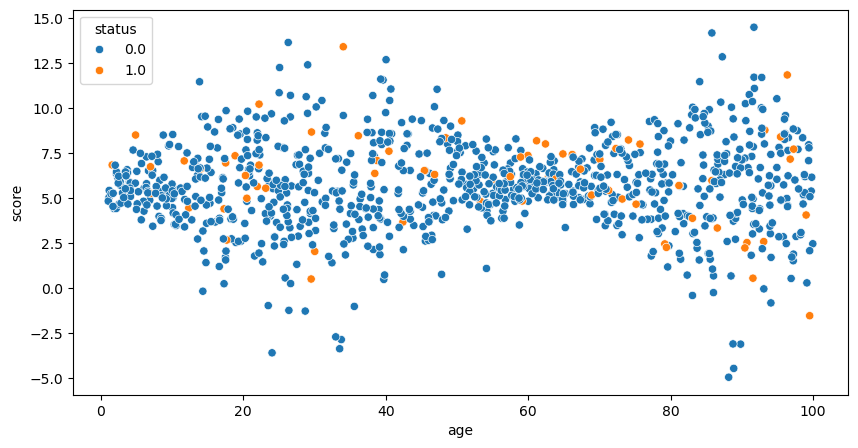

In [21]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='score',hue='status',data=df_het)

### Fit GAMLSS model on heteroskedastic data


In [22]:
# Initialize pynm w/ data, confounds, & bin parameters
m_het = PyNM(df_het,'score','status',['age'],bin_width=7, bin_spacing=1)

Models will be fit on full set of controls.


In [23]:
# Run models
m_het.loess_normative_model()
m_het.gp_normative_model(length_scale_bounds='fixed', length_scale=20) # see tutorial 2 for explanation of parameters settings
m_het.gamlss_normative_model(mu = "score~cs(age)", sigma = "~cs(age,df=2)", family='NO2')


/opt/anaconda3/envs/python-x64/lib/python3.9/site-packages/pynm/pynm.py:513: UserWarning: The residuals are not Gaussian!
  warnings.warn("The residuals are not Gaussian!")
/opt/anaconda3/envs/python-x64/lib/python3.9/site-packages/pynm/pynm.py:519: UserWarning: The residuals are heteroskedastic!
  warnings.warn("The residuals are heteroskedastic!")
R[write to console]: 



RRuntimeError: 

As we saw in tutorial 2, the simple LOESS strategy is effective whereas the GP fails to accurately estimate the CI for the heteroskedastic data resulting in skewed deviance scores.

Here we've added the GAMLSS model which explicitly models the variance as a function of age. This strategy captures the change in variance smoothly and results in evenly distributed deviance scores across age, neatly handling the heteroskedasticity and non-gaussian noise.

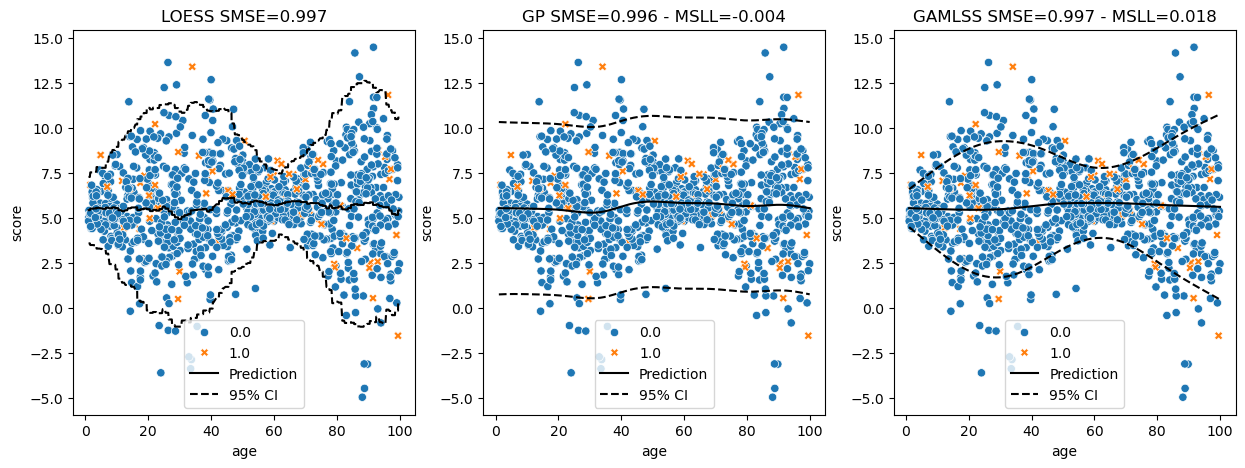

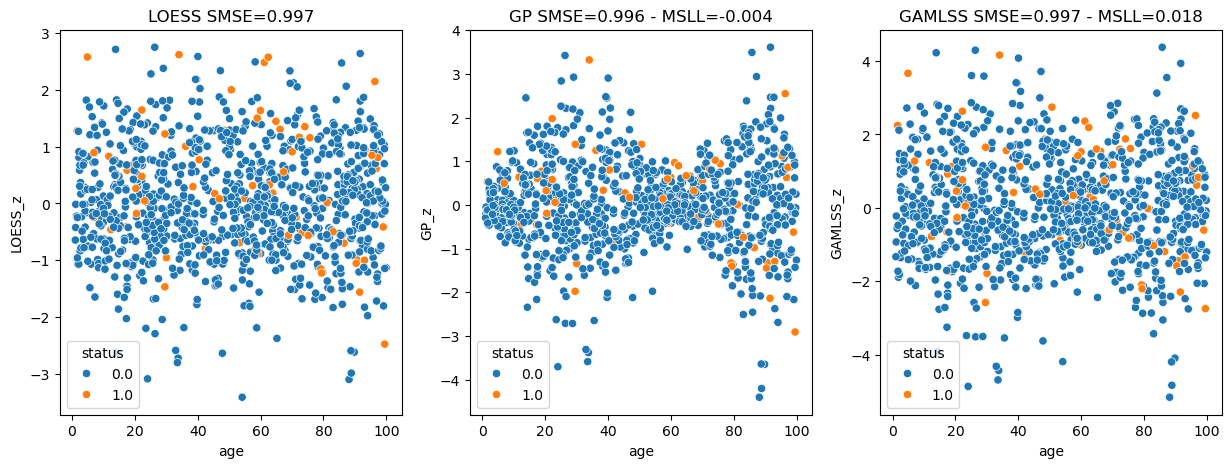

In [11]:

# Plot the data, model prediction, & 95% confidence interval
m_het.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_het.plot_z(confound='age')

In this example we will implement the recommended model from the Dinga et al. preprint, we'll use the same dataset as we did in tutorial 2.

Here we are using a dataset with:

- Multiple confounds (explanatory variables) (age, sex & site)
- Homoskedastic variance across the explanatory variable within each site
Gaussian noise
- A random offset in score for probands pulled from the gaussian distribution
- A random offset in score for sex pulled from the gaussian distribution
- A random offset in score for site pulled from the gaussian distribution (constant for all subjects from same site)

In [12]:
def g(age, sex, offset, prob = False):
    noise = np.random.normal(0, 0.1)
    if prob:
        return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex - 0.2 * np.random.uniform() + offset
    else:
        return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex + offset

def dataset_multivariate(n_sites=5,sample_size=35,seed=650):
    np.random.seed(seed)
    n_sites = n_sites
    age_min = (np.random.rand(n_sites)*50).astype(int)
    sites = pd.DataFrame(data={'sex_ratio': np.random.rand(n_sites),
                               'prob_ratio': 0.5*np.random.rand(n_sites),
                               'age_min': age_min,
                               'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int),
                               'score_shift': np.random.randn(n_sites)/4,
                               'sample_size': (sample_size+np.random.rand(n_sites)*sample_size*10).astype(int)})

    participants = []
    for site in sites.iterrows():
        for participant in range(int(site[1]['sample_size'])):
            sex = np.random.binomial(1, site[1]['sex_ratio'])
            prob = np.random.binomial(1, site[1]['prob_ratio'])
            age = np.random.uniform(site[1]['age_min'], site[1]['age_max'])
            score = g(age, sex, site[1]['score_shift'],prob=prob)
            participants.append([site[0], sex, prob, age, score])

    df = pd.DataFrame(participants, columns=['site', 'sex', 'status', 'age', 'score'])
    return df

In order to implement the baseline model recommended by Dinga et al. we add an additional column for sex, we also normalize the score - important for the GAMLSS model sigma parameter which is sensitive to magnitude.

In [14]:
# Create a dataset
df = dataset_multivariate()

# Add a column for male
df['male'] = 1 - df['sex']

# Normalise the response variable for GAMLSS
df['score'] = (df['score']-df['score'].mean())/df['score'].std()

df.head()

,site,sex,status,age,score,male
0,0,1,0,65.818713,0.360875,0
1,0,1,0,68.827045,-0.246850,0
2,0,0,0,61.660016,-0.145683,1
3,0,0,0,66.886592,0.436059,1
4,0,0,0,55.738248,-0.445415,1


Note: It is important to check the dtypes of all the columns in the input DataFrame before feeding it to the PyNM object when using the GAMLSS model. The implementation of GAMLSS in PyNM is a wrapper for the R library gamlss, so before the model can be fit the pandas DataFrame gets converted by rpy2 into an R DataFrame. The conversion can be finnicky, and works best for standard dtypes (float,int,str). Specifically, columns of type object and uint8 won't be properly converted.

If you get an error along the lines of "XXX has no attribute encode" when running the GAMLSS check the dtypes!

In [15]:
# Check df types
df.dtypes

site        int64
sex         int64
status      int64
age       float64
score     float64
male        int64
dtype: object

### Visualize data


Text(0.5, 1.0, 'By sex')

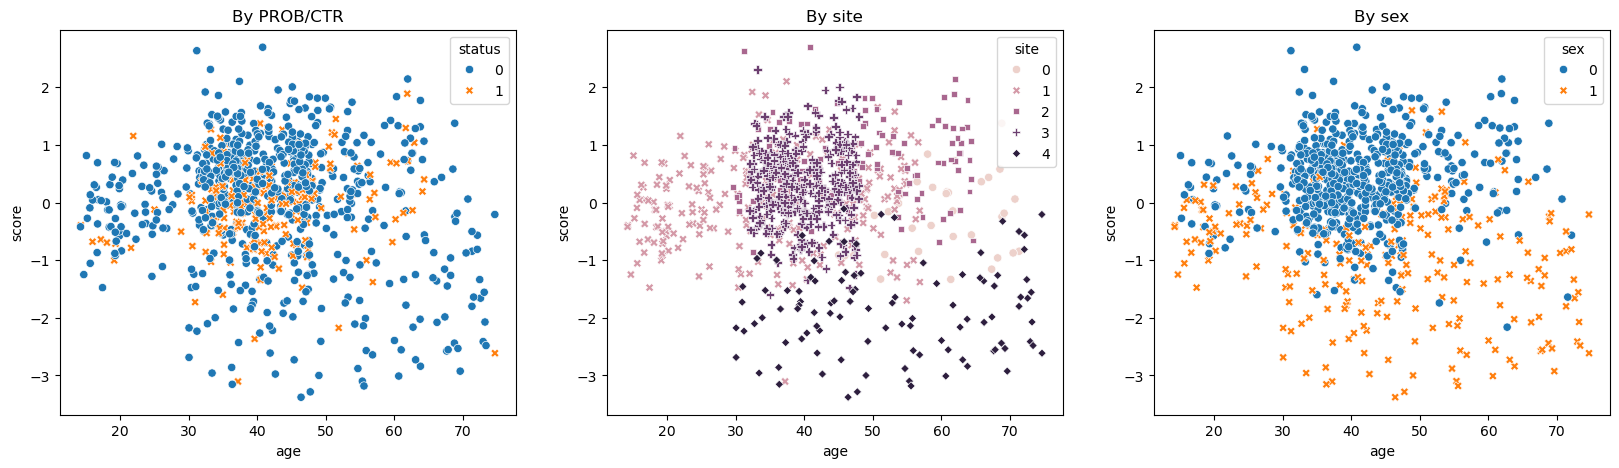

In [16]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

sns.scatterplot(data=df, x='age', y='score', hue='status', style='status',ax=ax[0])
sns.scatterplot(data=df, x='age', y='score', hue='site', style='site',ax=ax[1])
sns.scatterplot(data=df, x='age', y='score', hue='sex', style='sex',ax=ax[2])

ax[0].set_title('By PROB/CTR')
ax[1].set_title('By site')
ax[2].set_title('By sex')

### Fit GAMLSS

In [17]:
# Initialise pynm with data, confounds and bin parameters
m = PyNM(df, 'score', 'status', ['age', 'c(sex)', 'c(site)'])

Models will be fit on full set of controls.



Here we've implemented the recommended baseline model from the Dinga et al preprint:


![alt text](https://raw.githubusercontent.com/ppsp-team/PyNM/52de5b73ffd2cb4b04352e348f042dd695be3c87/tutorials/image3.jpg)

### Formula explanation

**mu:** This is the formula defining the location (mean) model for score.

- ps(age*sex): ps() represents a penalized spline smoothing function applied to age*sex. This captures nonlinear interactions between age and sex, allowing the model to fit flexible curves for the score across combinations of age and sex. The interaction term age*sex means that the model can capture different age effects for each sex category.

- ps(age*male): Here, ps() is used to create another penalized spline on age*male. If male is a binary indicator (e.g., 1 for male and 0 for female), this term allows the age effect to vary for each sex group, again adding flexibility to the fit. This could be redundant with age*sex, depending on the data, but might also add an independent effect of "male" on age.

- random(as.factor(site)): This term adds a random effect for site, which is a categorical variable (converted with as.factor()). Random effects account for variability across different sites (e.g., hospitals, testing centers) and help capture site-specific deviations from the mean.

**sigma:** This defines the scale (variance) model for score.

- ps(age): Applying a penalized spline ps(age) to the sigma model allows the spread of score to vary smoothly with age. This means that the variability in score (how spread out the scores are) can increase or decrease at different ages.

- random(as.factor(site)): Including the random effect for site in sigma allows the variance to differ across sites. For example, if some sites have more diverse or variable scores, this term will let the model account for that site-specific variability.

In [24]:
# Run model
m.gamlss_normative_model(mu = 'score ~ ps(age*sex) + ps(age*male) + random(as.factor(site))', sigma = '~ ps(age) + random(as.factor(site))')

GAMLSS-RS iteration 1: Global Deviance = 1403.889 
GAMLSS-RS iteration 2: Global Deviance = 1273.816 
GAMLSS-RS iteration 3: Global Deviance = 1226.807 
GAMLSS-RS iteration 4: Global Deviance = 1210.348 
GAMLSS-RS iteration 5: Global Deviance = 1204.135 
GAMLSS-RS iteration 6: Global Deviance = 1201.705 
GAMLSS-RS iteration 7: Global Deviance = 1200.698 
GAMLSS-RS iteration 8: Global Deviance = 1200.277 
GAMLSS-RS iteration 9: Global Deviance = 1200.09 
GAMLSS-RS iteration 10: Global Deviance = 1200.008 
GAMLSS-RS iteration 11: Global Deviance = 1199.969 
GAMLSS-RS iteration 12: Global Deviance = 1199.954 
GAMLSS-RS iteration 13: Global Deviance = 1199.948 
GAMLSS-RS iteration 14: Global Deviance = 1199.946 
GAMLSS-RS iteration 15: Global Deviance = 1199.945 
GAMLSS-RS iteration 16: Global Deviance = 1199.944 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In predict.gamlss(model, newdata = test_data, parameter = "sigma") :
R[write to console]: 
 
R[write to console]:  There is a discrepancy  between the original and the re-fit 
 used to achieve 'safe' predictions 
 



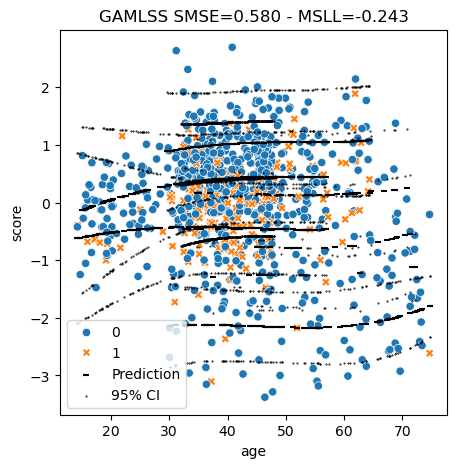

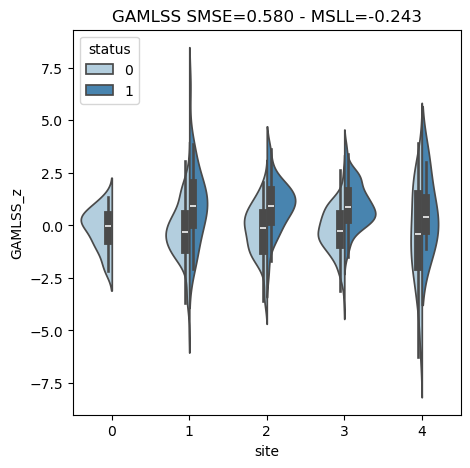

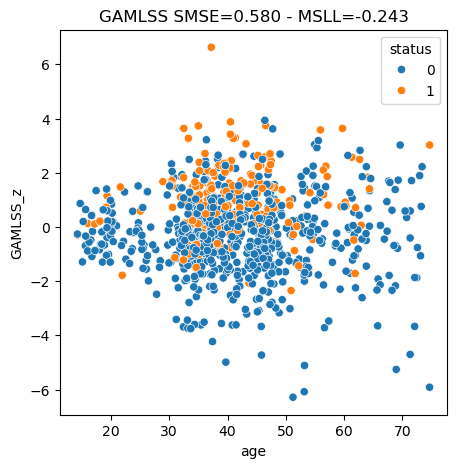

In [25]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m.plot_z(confound='site')
m.plot_z(confound='age')

## Full GAMLSS model outputs
We can explore the full outputs of the GAMLSS model by accessing the data attribute of the PyNM object. In general, all model outputs will be added as columns to the PyNM dataframe or as attributes to the PyNM object.

We won't look at the rest of the columns in data since they were covered in tutorials 1 & 2.

In [26]:
GAMLSS_cols = [col for col in m.data.columns if 'GAMLSS' in col]
m.data[GAMLSS_cols].head()

,GAMLSS_pred,GAMLSS_sigma,GAMLSS_residuals,GAMLSS_z
0,-0.684107,-0.544221,1.044982,-1.920142
1,-0.613739,-0.533668,0.366889,-0.687485
2,0.150748,-0.545436,-0.296431,0.543475
3,0.193192,-0.541520,0.242867,-0.448491
4,0.134617,-0.533672,-0.580033,1.086872


### Description of columns

- GAMLSS_pred
    - Prediction of the GAMLSS model (mean of predictive distribution).
- GAMLSS_sigma
    - Sigma parameter of the GAMLSS model.
- GAMLSS_residuals
    - Difference between actual value of score and GAMLSS_pred.
- GAMLSS_z
    - GAMLSS_residuals / GAMLSS_sigma.
    
    Warning: this assumes that GAMLSS_sigma is equivalent to the standard deviation, this is NOT true in all cases and GAMLSS_z should be treated with caution.

## Summary

- GAMLSS can model multi-parameter distributions, making them very flexible.
    - We can specify models for each of location, scale, shape and skewness.
- GAMLSS can overcome the homoskedasticity and gaussian noise assumptions of the GP & SVGP models.
- GAMLSS are advanced statistical models that must be used with caution.
    - Good design choices required, cannot rely on off the shelf defaults.
- GAMLSS are sensitive to the magnitude of the data.
- The PyNM implementation is a wrapper for the R gamlss library.
    - Need to make sure the input DataFrame for the PyNM object has correct dtypes before using GAMLSS.
- The sigma parameter of the GAMLSS is not always equivalent to the standard deviation, GAMLSS_z must be treated with caution as a result.

## Resources
- Dinga et al. 2021 Normative modeling of neuroimaging data using generalized additive models of location scale and shape
- R gamlss package documentation